# Bruk av data fra DataFabrikken 2.0 datasjø og eksterne kilder
### Denne Jupyter-notebook'en inneholder følgende eksempler
* Hente og vise data fra Enhetsregisteret (lagret i datasjø) [TODO lenke til avsnitt-bokmerke]
* Hente og vise data fra Poststedsregisteret (lagret i datasjø) [TODO lenke til avsnitt-bokmerke]
* Hente og vise Covid-19 data (fra Johns Hopkins, lagret i datasjø) koblet til eksterne befolkningsdata (hentet direkte) [lenke til avsnitt-bokmerke]
* TODO Vise et enkelt ML-case?

In [1]:
# TODO: Remove this

# Good datasets for DataFabrikken "HelloWorld" examples

# Covid-19 datasets, map projections, etc.:
# https://opensource.com/article/20/4/python-map-covid-19
# https://github.com/CSSEGISandData/COVID-19

# https://data.brreg.no/enhetsregisteret/api/enheter/lastned

# Useful datasets for ML:
# https://github.com/jbrownlee/Datasets
# http://www.bedreinnsikt.no/datasett-postnummer-internasjonal.html
# https://github.com/maazh/IMDB-Movie-Dataset-Analysis
# https://github.com/SrinidhiRaghavan/AI-Sentiment-Analysis-on-IMDB-Dataset

# Data catalog: What capabilitites?
# - PII identification? Scan and classify sensitive data? Norway not well covered by Purview scan (only SSN so far)
# - English/Norwegian column name mapping for easier search.
#   English is most common in many datasets. Most Norwegian datasets have Norwegian column names,
#   should they be mapped to English for unified search/understanding? How to handle multi-language users?
#   for easier search capabilities for non-Norwegian speakers/users?

In [ ]:
!pip freeze

In [67]:
from __future__ import annotations

from typing import Any, Dict, List, Tuple, Iterator, Optional

# import plotly.express as px
# import pycountry

# import zipfile
import zlib
from io import StringIO
# import parquet
import pandas as pd
from pandas.io.json import json_normalize
# import rdfpandas
# from itertools import chain
# import rdflib
import numpy as np
import csv
import os
import time
import re
from datetime import datetime
import uuid
import math
import json
import timeit
import requests
import jsonschema
from jsonschema import validate
import matplotlib as mpl
from matplotlib import pyplot as plt
import seaborn as sns
from os.path import exists
import io
import time
import yaml
import collections
import scipy.stats
from scipy.stats import kurtosis, skew
import dicttoxml
from dict2xml import dict2xml
from dicttoxml import dicttoxml
import xml.etree.ElementTree as ET

BytesIO = pd.io.common.BytesIO

# For Azure Blob Storage:
from azure.storage.blob import BlobServiceClient, BlobClient, ContainerClient
from azure.core.exceptions import ResourceNotFoundError

import sklearn
from sklearn import metrics, multiclass, calibration, preprocessing, svm, model_selection
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, RepeatedStratifiedKFold, \
    StratifiedShuffleSplit, LeavePOut, LeaveOneOut, cross_val_score # TODO: For doing CV
from sklearn.preprocessing import scale, LabelEncoder, StandardScaler, OneHotEncoder, Normalizer, MinMaxScaler, MaxAbsScaler
from sklearn.preprocessing import MultiLabelBinarizer # For xgboost
from sklearn.feature_selection import SelectFromModel, SelectKBest, chi2
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer
# from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.metrics import precision_score, recall_score, f1_score, multilabel_confusion_matrix, zero_one_loss, ConfusionMatrixDisplay
from sklearn.exceptions import UndefinedMetricWarning

from sklearn.linear_model import RidgeClassifier
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier, Perceptron, PassiveAggressiveClassifier
from sklearn.naive_bayes import BernoulliNB, ComplementNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier, NearestCentroid
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.extmath import density

from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
from nltk.stem.snowball import SnowballStemmer # https://www.nltk.org/howto/stem.html

import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# Install GDAL for heatmaps/map projections:
# https://www.lfd.uci.edu/~gohlke/pythonlibs/#gdal
# python -m pip install <download folder>/GDAL-3.3.3-cp37-cp37m-win_amd64.whl
# https://www.lfd.uci.edu/~gohlke/pythonlibs/#fiona
# python -m pip install <download folder>/Fiona-1.8.20-cp37-cp37m-win_amd64
# pip install geopandas

# from helpers import slug
# from osgeo import gdal
# import geopandas as gpd

%matplotlib inline

print('Versjons-informasjon fra noen av de installerte Python-bibliotekene:')
print(f'jsonschema {jsonschema.__version__}')
print(f'matplotlib {mpl.__version__}')
print(f'numpy {np.__version__}')
print(f'pandas {pd.__version__}')
print(f'seaborn {sns.__version__}')
print(f'pyyaml {yaml.__version__}')
print(f'rdflib {rdflib.__version__}')
print(f'pycountry {pycountry.__version__}')
print(f'geopandas {gpd.__version__}')

Versjons-informasjon fra noen av de installerte Python-bibliotekene:
jsonschema 4.0.1
matplotlib 3.4.3
numpy 1.20.3
pandas 1.3.4
seaborn 0.11.2
pyyaml 5.1.2
rdflib 6.0.2
pycountry 20.7.3
geopandas 0.10.2


In [2]:
# Sett opp noen standardinnstillinger for alle plott
plt.rc('axes', axisbelow=True)
mpl.rcParams['axes.labelsize'] = 14

In [69]:
STOPWORDS = []
stemmer = SnowballStemmer('english') 
tknzr = TweetTokenizer()

WORDS_REGEX = "\w{0,50}\.?'?\w{1,50}"

def clean_text(data): # Remove punctuation and special chars, then lowercase
    return ' '.join(re.compile(WORDS_REGEX).findall(str(data).lower()))

def sentence_tokenizer(sentences):
    tokens = re.split('\.\s{0,1}|\?|!', sentences);
    return [x for x in tokens if x != '']

def count_words(text):
    text_split = clean_text(text).split()
    return len(text_split)

def tokenize(text):
    tokens = tknzr.tokenize(text) #tokenize
    filtered_tokens = []
    # Filter out the tokens which don't contain letters or digits(e.g. raw punctuation)
    for token in tokens:
        # if re.search('[a-zA-Z]|\d', token):
        # if re.search('[a-zA-Z]', token) and (not re.search(r'\d', token)): # Only tokens that contain letters
        if (not re.search("[^a-zA-Z-' ]", token)) and (len(token) > 1):
            # Any token that contains anything else except letters and possibly '-', is filtered out.
            # Also all tokens of length 1 are removed (single letters)
            filtered_tokens.append(token)
    return filtered_tokens

# define tokenize_and_stem, in order to use stems for algorithms
def tokenize_and_stem(text):
    tokens = tknzr.tokenize(text) #tokenize
    filtered_tokens = []
    # Filter out the tokens which don't contain letters or digits(e.g. raw punctuation)
    for token in tokens:
        # if re.search('[a-zA-Z]|\d', token):
        # if re.search('[a-zA-Z]', token) and (not re.search(r'\d', token)): # Only tokens that contain letters
        if (not re.search("[^a-zA-Z-' ]", token)) and (len(token) > 1):
            # Any token that contains anything else except letters and possibly '-', is filtered out.
            # Also all tokens of length 1 are removed (single letters)
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    stems = [item for item in stems if item not in STOPLIST]
    return stems

def stem(text):
    stems = [stemmer.stem(t) for t in text]
    return stems

def get_avg_word_length(text):
    tokens = tokenize(text)
    return np.round(np.mean([len(x) for x in tokens]), 2)
                    
def get_avg_sentence_length(text):
    sentences = sentence_tokenizer(text)
    if len(sentences) > 0:
        return np.round(np.mean([len(x.split()) for x in sentences]), 2)
    else:
        return 0

def get_hapaxes_dislegomena_ratio(text):
    hapaxes = []
    dislegomena = []
    tokens = [x.lower() for x in tokenize(text)]
    c = Counter(tokens)
    for w in c:
        if c[w] == 1:
            hapaxes.append(w)
        if c[w] == 2:
            dislegomena.append(w)
    if len(hapaxes) == 0:
        return 0
    else:
        return len(dislegomena) / len(hapaxes)
    
def extract_body(text):
    text = str(text)
    result = re.search('Lines: \d+\n', text)
    if result is not None:
        text = text[result.span()[1]:]
    for stopword in STOPWORDS:
        if stopword in text:
            text = text.replace(stopword, '')
    # TODO: Use regex to filter email entities, etc.
    # TODO: Change "it's " to "it is" etc.
    return text

### Sett opp tilgang til datasjø

In [61]:
# https://docs.microsoft.com/en-us/azure/architecture/data-science-process/explore-data-blob

class DataLake():
    '''
    Klasse for å hente datasett for analyse fra Azure Data Lake (blob storage)
    TODO: Pandas profiling?
    '''
    DEBUG = True
    storage_container = 'data'
    # TODO: Husk fjerne navn/nøkkel før check-in (legg på KeyVault aksess-håndtering med secret her)
    storage_name = '---'
    storage_access_key = '---'
    
    def __init__(self):
        blob_service_client = BlobServiceClient(account_url="https://" + self.storage_name + ".blob.core.windows.net",
                                                credential=self.storage_access_key)
        self.container_client = blob_service_client.get_container_client(self.storage_container)

        if self.DEBUG:
            print('Lister ut data...')
            try:
                for blob in self.container_client.list_blobs(): # (name_starts_with='Covid-19'):
                    print('Fant blob:', blob.name)
            except ResourceNotFoundError:
                print('Finner ikke container!')
            
    def get_data(self, blob_name, delimiter=','):
        blob_client = self.container_client.get_blob_client(blob_name)
        blob_content = blob_client.download_blob().readall() # Som bytes
        # blob_content = blob_client.download_blob().content_as_text()
        
        blob_name = blob_name.upper()
        if not 'ZIP' in blob_name and not 'GZ' in blob_name:
            if 'CSV' in blob_name:
                print('Henter CSV-fil...')
                self.df = pd.read_csv(BytesIO(blob_content), low_memory=False, delimiter=delimiter, header=0,
                                     doublequote=False, quotechar='"', escapechar='\\', quoting=csv.QUOTE_ALL)
                # Konverterer bytes-array til Pandas DataFrame
                # df = pd.read_csv(StringIO(blob_content), header=1) # Konverterer bytes-array til Pandas DataFrame
            elif 'XLS' in blob_name:
                print('Henter Excel-fil...')
                self.df = pd.read_excel(BytesIO(blob_content), engine='openpyxl') # Konverterer bytes-array til pandas DataFrame 
            elif 'JSON' in blob_name:
                print('Henter JSON-fil...')
                self.df = pd.read_json(BytesIO(blob_content)) # Konverterer bytes-array til Pandas DataFrame
            return self.df
        else:
            if 'GZ' in blob_name:
                print('Henter GZ-fil...')
                buffer = zlib.decompress(blob_content, 32 + zlib.MAX_WBITS)  # offset 32 for å hoppe over header
                return buffer # Return raw?


In [62]:
# Opprett en instans av DataLake-klassen
dl = DataLake()

Lister ut data...
Fant blob: Covid-19/covid_19_daily_data.csv
Fant blob: Enhetsregisteret/Enhetsregisteret.json
Fant blob: Enhetsregisteret/Enhetsregisteret.json.gz
Fant blob: MovieReviews/moviereviews.csv
Fant blob: PostalCodes/PostalCodes_Norway.xlsx
Fant blob: Sources/FileSources.csv


### Eksempel 1: Bruke data fra Enhetsregisteret (data fra datasjø)

In [6]:
json_buffer = dl.get_data('Enhetsregisteret/Enhetsregisteret.json.gz')

Henter GZ-fil...


In [7]:
json_file = json.loads(json_buffer)

In [8]:
# Denne konverteringen fra json til dataframe tar et minutt eller to...
df_orgunits = pd.json_normalize(json_file)
df_orgunits.head(n=5)

,organisasjonsnummer,navn,registreringsdatoEnhetsregisteret,registrertIMvaregisteret,antallAnsatte,registrertIForetaksregisteret,registrertIStiftelsesregisteret,registrertIFrivillighetsregisteret,konkurs,underAvvikling,...,sisteInnsendteAarsregnskap,naeringskode2.beskrivelse,naeringskode2.kode,naeringskode2.hjelpeenhetskode,frivilligMvaRegistrertBeskrivelser,naeringskode1.hjelpeenhetskode,naeringskode3.beskrivelse,naeringskode3.kode,overordnetEnhet,naeringskode3.hjelpeenhetskode
0,922924368,- A THOUSAND WORDS - ØDEGÅRDEN GJERRUD TRANSLA...,2019-06-19,True,0,False,False,False,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,916627939,- P A L M E R A -,2016-01-26,False,0,False,False,False,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,911963582,- TTT- WINES TORE EUGEN KRISTIANSEN,2013-05-25,False,0,False,False,False,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,988539473,-EBE- DATA Eyolf Berg,2005-08-20,False,0,False,False,False,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,922936919,-VEIEN- MED ANITA HELLEBØ-STOREIDE,2019-06-21,False,0,True,False,False,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [131]:
# Vis litt statistikk på Enhetsregisteret
df_orgunits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1055250 entries, 0 to 1055249
Data columns (total 46 columns):
 #   Column                                     Non-Null Count    Dtype 
---  ------                                     --------------    ----- 
 0   organisasjonsnummer                        1055250 non-null  object
 1   navn                                       1055250 non-null  object
 2   registreringsdatoEnhetsregisteret          1055250 non-null  object
 3   registrertIMvaregisteret                   1055250 non-null  bool  
 4   antallAnsatte                              1055250 non-null  int64 
 5   registrertIForetaksregisteret              1055250 non-null  bool  
 6   registrertIStiftelsesregisteret            1055250 non-null  bool  
 7   registrertIFrivillighetsregisteret         1055250 non-null  bool  
 8   konkurs                                    1055250 non-null  bool  
 9   underAvvikling                             1055250 non-null  bool  
 10  underT

Finn antall ansatte for en spesifikk organisatorisk enhet
Antall ansatte i TietoEVRY Norge:
                            navn  antallAnsatte
1044739  TIETOEVRY ACCOUNTING AS             57
1054829      TIETOEVRY NORWAY AS           3217

Største organisatoriske enheter, antall ansatte:


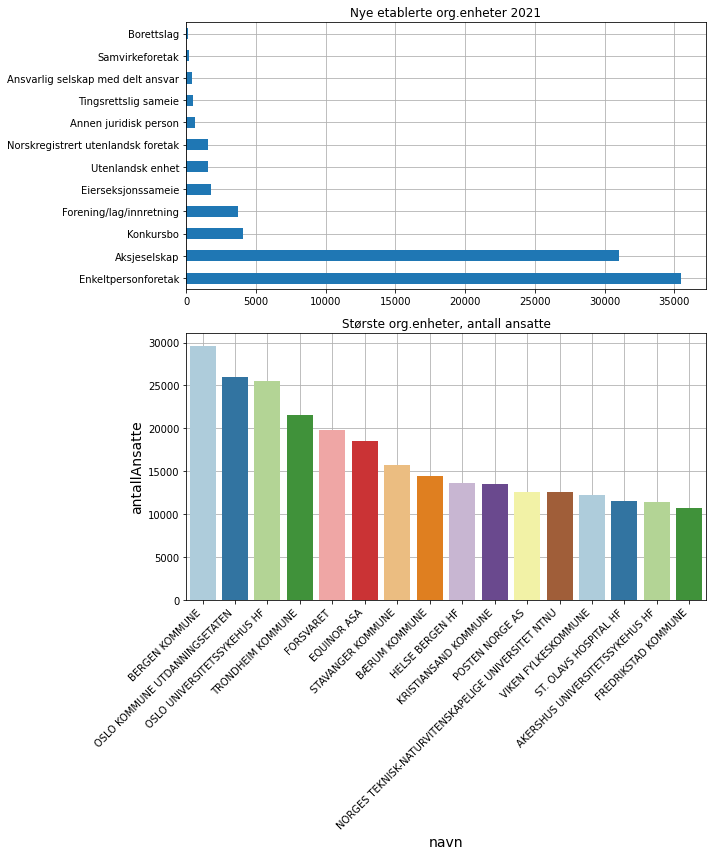

,navn,antallAnsatte
981279,BERGEN KOMMUNE,29628
998584,OSLO KOMMUNE UTDANNINGSETATEN,25940
998642,OSLO UNIVERSITETSSYKEHUS HF,25493
1006558,TRONDHEIM KOMMUNE,21539
986930,FORSVARET,19745
985678,EQUINOR ASA,18564
1003631,STAVANGER KOMMUNE,15732
983095,BÆRUM KOMMUNE,14435
989420,HELSE BERGEN HF,13580
992799,KRISTIANSAND KOMMUNE,13559


In [154]:
# Finn antall ansatte for en spesifikk organisatorisk enhet.
# Hvis vi ikke er helt sikre på navnet kan vi bruke "wildcard"-søk med "contains":
print('Finn antall ansatte for en spesifikk organisatorisk enhet\nAntall ansatte i TietoEVRY Norge:')
print(df_orgunits[['navn','antallAnsatte']].loc[df_orgunits['navn'].str.contains('TIETOEVRY') & \
                                               df_orgunits['antallAnsatte'] > 0])

# Finn antall ansatte i de største organisatoriske enhetene
print('\nStørste organisatoriske enheter, antall ansatte:')
n = 16
df_subset = df_orgunits[['navn', 'antallAnsatte']].sort_values(by='antallAnsatte', ascending=False)[0:n]

# Vis nye etablerte enheter i år
fig, ax = plt.subplots(2, 1, figsize=(10, 12))
df_orgunits['organisasjonsform.beskrivelse'] \
      .loc[df_orgunits['registreringsdatoEnhetsregisteret'] >= '2021-01-01'].value_counts()[:-12].plot(kind='barh', ax=ax[0])
ax[0].set_title('Nye etablerte org.enheter 2021')
ax[0].grid()

sns.barplot(x='navn', y='antallAnsatte', data=subset, palette='Paired', ax=ax[1]) \
    .set_title('Største org.enheter, antall ansatte')
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=45, horizontalalignment='right')
ax[1].grid()
plt.tight_layout()
plt.show()

df_subset.head(n=n)

### Eksempel 2: Bruke poststedsdata fra Posten Bring (data fra datasjø)

In [41]:
df_postal_codes = dl.get_data('PostalCodes/PostalCodes_Norway.xlsx')
df_postal_codes.head()

,Postnummer,Poststed,Kommunenummer,Kommunenavn,Kategori
0,1,OSLO,301,OSLO,P
1,10,OSLO,301,OSLO,B
2,15,OSLO,301,OSLO,B
3,18,OSLO,301,OSLO,G
4,21,OSLO,301,OSLO,P


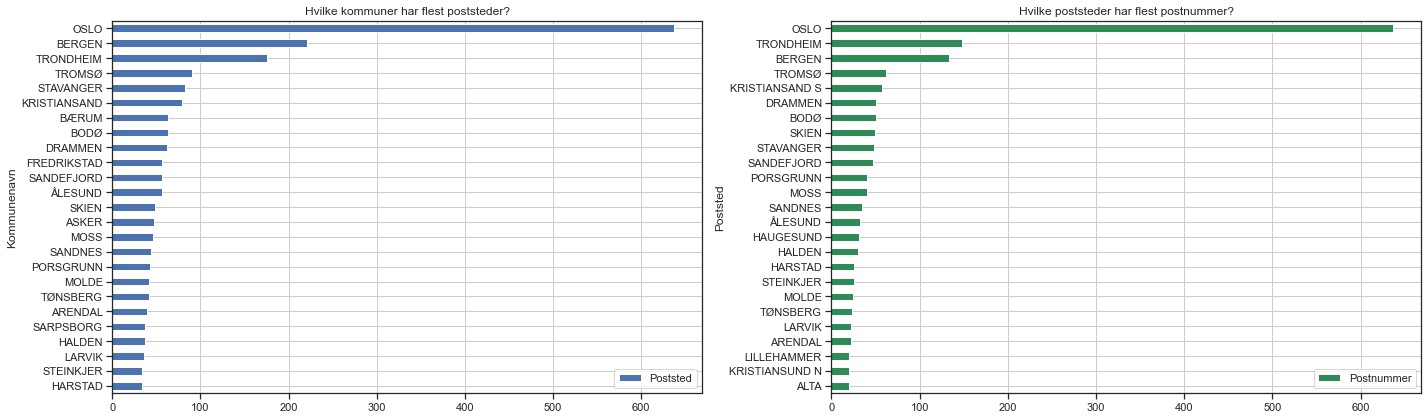

In [141]:
_, ax = plt.subplots(1, 2, figsize=(20, 6))
n = 25 # Hvor mange vil vi vise som "topp <n>"?

# Hvilke kommuner har flest poststeder?
df_postal_codes_count_by_municipality = df_postal_codes[['Kommunenavn','Poststed']].groupby('Kommunenavn').count().sort_values(by='Poststed', ascending=True)[-n:]
df_postal_codes_count_by_municipality.plot(kind='barh', ax=ax[0]).set_title('Hvilke kommuner har flest poststeder?')
ax[0].grid()

# Hvilke poststeder har flest postnummer?
df_postal_codes_count_by_location = df_postal_codes[['Poststed','Postnummer']].groupby('Poststed').count().sort_values(by='Postnummer', ascending=True)[-n:]
df_postal_codes_count_by_location.plot(kind='barh', color='seagreen', ax=ax[1]).set_title('Hvilke poststeder har flest postnummer?')
ax[1].grid()

plt.tight_layout()
plt.show()

### Eksempel 3: Bruke Covid-19 data (data i datasjø, samt eksternt datasett)
Covid-19 datasettet i datasjøen er et datasett som oppdateres og hentes daglig fra Johns Hopkins-universitetet i Baltimore, USA. Det eksterne datasettet med befolkningsstatistikk for verdens land er hentet fra FN.

In [47]:
# Hent data fra datasjø
df = dl.get_data('Covid-19/covid_19_daily_data.csv')

# Se på litt statistikk om datasettet
print('Kolonne-navn og datatyper:')
print(df.dtypes)
print('\nAntall nullverdier/tomme felt:')
print(df.isnull().sum())
print('\nKolonner i datasettet:', df.columns)
print('\nLitt statistikk på numeriske kolonner i datasettet:', df.columns)
print(df.describe()) # Vis statistikk på numeriske kolonner
print('\nDato fra-til:', np.min(df['Date']), np.max(df['Date']))
print('Antall land:', df['Country'].nunique())

# Vis noen rader fra DataFame vi har hentet fra datasjø
df.tail()

# Hent info om datasettet (TODO: Bytt ut med pandas_profiling?)
dataset_properties = dl.create_file_properties_extended()
dataset_properties

Henter CSV-fil...
Kolonne-navn og datatyper:
Date         object
Country      object
Confirmed     int64
Recovered     int64
Deaths        int64
dtype: object

Antall nullverdier/tomme felt:
Date         0
Country      0
Confirmed    0
Recovered    0
Deaths       0
dtype: int64

Kolonner i datasettet: Index(['Date', 'Country', 'Confirmed', 'Recovered', 'Deaths'], dtype='object')

Litt statistikk på numeriske kolonner i datasettet: Index(['Date', 'Country', 'Confirmed', 'Recovered', 'Deaths'], dtype='object')
          Confirmed     Recovered         Deaths
count  1.317120e+05  1.317120e+05  131712.000000
mean   4.891375e+05  1.783547e+05   10927.018912
std    2.498119e+06  1.076949e+06   48056.841917
min    0.000000e+00  0.000000e+00       0.000000
25%    7.120000e+02  0.000000e+00       9.000000
50%    1.388050e+04  1.486000e+03     221.000000
75%    1.656440e+05  3.778950e+04    3014.000000
max    4.798078e+07  3.097475e+07  773770.000000

Dato fra-til: 2020-01-22 2021-11-23
Antall l

,column_name,data_type,count,missing,unique,mean,mode,stdev,var,minlength,avglength,maxlength,skew,kurtosis,entropy,min,percentile_25,percentile_50,percentile_75,max
0,Date,object,131712,0,672,NaN,2020-01-22,NaN,NaN,10,10.0,10,NaN,NaN,9.392317,NaN,NaN,NaN,NaN,NaN
1,Country,object,131712,0,196,NaN,Afghanistan,NaN,NaN,2,9.0,32,NaN,NaN,7.61471,NaN,NaN,NaN,NaN,NaN
2,Confirmed,int64,131712,0,67563,489137.543785,0,2498109.248234,6240549816112.910156,NaN,NaN,NaN,11.340893,151.501856,14.033342,0,712.0,13880.5,165644.0,47980780
3,Recovered,int64,131712,0,44984,178354.712912,0,1076945.329322,1159811242348.358154,NaN,NaN,NaN,16.426388,357.644387,10.782634,0,0.0,1486.0,37789.5,30974748
4,Deaths,int64,131712,0,23755,10927.018912,0,48056.659485,2309442520.836324,NaN,NaN,NaN,8.948093,97.62444,10.520697,0,9.0,221.0,3014.0,773770


In [48]:
dates = pd.to_datetime(df['Date'], format='%Y-%m-%d')
df['Date_Converted'] = dates
# df.dtypes

Hvilket land har hatt flest dødsfall?
              Date Country  Confirmed  Recovered  Deaths Date_Converted
122975  2021-11-23      US   47980780          0  773770     2021-11-23


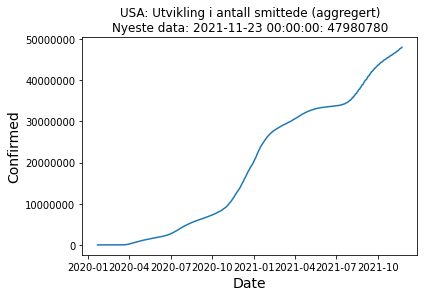

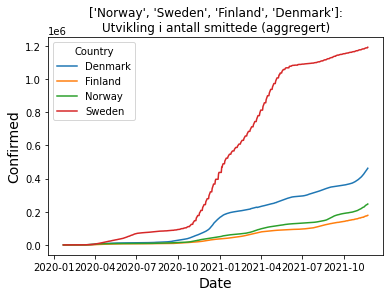

In [49]:
# Hvilket land har hatt størst antall dødsfall?
print('Hvilket land har hatt flest dødsfall?')
print(df.loc[df['Deaths'] == np.max(df['Deaths'])]) # USA

# Vis statistikk for USA
# Først konverterer vi datokolonnen (strengverdier) til en "ordentlig" dato
# df['Date'] = df['Date'].map(lambda x: datetime.strptime(str(x), '%Y-%m-%d'))

# Plott utviklingen over tid for USA
df_US = df.loc[df['Country'] == 'US'].copy()
# Gjør om dato-kolonnen fra strengverdi til dato
df_US['Date'] = df_US['Date'].map(lambda x: datetime.strptime(x, '%Y-%m-%d'))
# print(df_US.tail())

plt.ticklabel_format(style='plain', axis='y')

current_date = df_US['Date'].iloc[-1]
current_confirmed = df_US['Confirmed'].iloc[-1]
sns.lineplot(x='Date', y='Confirmed', data=df_US).set_title(f'USA: Utvikling i antall smittede (aggregert)\nNyeste data: {current_date}: {current_confirmed}')
plt.show()

# Plott utviklingen over tid for flere land
countries = ['Norway', 'Sweden','Finland','Denmark']
df_countries = df.loc[df['Country'].isin(countries)].copy()
# Gjør om dato-kolonnen fra strengverdi til dato
df_countries['Date'] = df_countries['Date'].map(lambda x: datetime.strptime(x, '%Y-%m-%d'))

sns.lineplot(x='Date', y='Confirmed', hue='Country', data=df_countries).set_title(f'{countries}:\nUtvikling i antall smittede (aggregert)')
plt.show()

### Vis Covid data for utvalgte land, vis andel smittede og dødsfall (data fra datasjø) i forhold til landets folketall (hentet fra ekstern kilde)
Dette eksemplet viser hvordan vi kan benyttede eksisterende data i datasjøen og berike dem med å koble inn andre datakilder.

I dette tilfellet kobler vi Covid-datasettet fra datasjøen med eksterne data fra https://population.un.org

#### Hent befolkningsdata fra eksternt datasett

In [50]:
COUNTRY_REGION = 'Country/Region'
CONFIRMED = 'confirmed'
DEATHS = 'deaths'

# Det er i noen tilfeller benyttet ulike land-navn i de to datasettene, så vi gjør en mapping for å få disse enhetlige
COUNTRY_MAPPINGS = {'Russian Federation':'Russia', 'United States of America':'US'}
# Vi ønsker å se på statistikk fra disse landene
COUNTRIES = ['Norway', 'Sweden', 'Denmark', 'Finland', 'Russia', 'US', 'United Kingdom', 'Germany']

# Hent befolkningsdata i Excel-format fra eksternt nettsted
url = 'https://population.un.org/wpp/Download/Files/1_Indicators%20(Standard)/EXCEL_FILES/1_Population/' + \
        'WPP2019_POP_F01_1_TOTAL_POPULATION_BOTH_SEXES.xlsx'

# Excel-filene har noen overskrifter etc. i topp-radene. Vi fjerner disse slik at vi kan lese filen korrekt
print('Henter data fra ekstern kilde...')
df_pop = pd.read_excel(url, skiprows=range(1, 16))
print('Data hentet!')

df_pop.columns = df_pop.iloc[0] # Vi benytter rad 0 i dataframe som kolonne-navn
df_pop.drop(0, inplace=True) # Og så fjerner vi rad 0

# Vi fikser et langt kolonne-navn
df_pop = df_pop.rename(columns={'Region, subregion, country or area *': COUNTRY_REGION})

# Vi ønsker mest mulig oppdaterte befolkningsdata, så henter bare ut data for 2020 (siste år vi har data for)
df_pop = df_pop[[COUNTRY_REGION,'2020']]

Henter data fra ekstern kilde...
Data hentet!


In [51]:
# Vi fikser noen land-navn der det er forskjeller i de to datasettene
# (merk at mappingen ikke er gjort for alle land-navn, kun de vi ønsker å vise i dette eksemplet, så det kan være andre ulikheter i datasettene)

# print(df_pop[COUNTRY_REGION].value_counts())

for country in np.unique(df_pop[COUNTRY_REGION]):
    if country in COUNTRY_MAPPINGS:
        print(f'Fikser {country} - endrer navn til {COUNTRY_MAPPINGS[country]}')
        df_pop[COUNTRY_REGION].loc[df_pop[COUNTRY_REGION] == country] = COUNTRY_MAPPINGS[country]

df_pop_sub = df_pop[df_pop[COUNTRY_REGION].isin(COUNTRIES)].copy() # Vi tar ut kun de landene vi ønsker å visualisere

# Vi gjør befolkningsantallet numerisk og multipliserer med 1000 for å matche formatet i det andre datasettet
df_pop_sub['Current_population'] = (df_pop_sub['2020'].astype(float) * 1000).astype(int)
del df_pop_sub['2020']
df_pop_sub

Fikser Russian Federation - endrer navn til Russia
Fikser United States of America - endrer navn til US


,Country/Region,Current_population
240,Russia,145934460
245,Denmark,5792203
248,Finland,5540718
254,Norway,5421242
255,Sweden,10099270
256,United Kingdom,67886004
278,Germany,83783945
289,US,331002647


#### Lag plott for Covid-19 bekreftet smittede og dødsfall (fraksjon av total befolkning) med data fra datasjø koblet til eksterne data

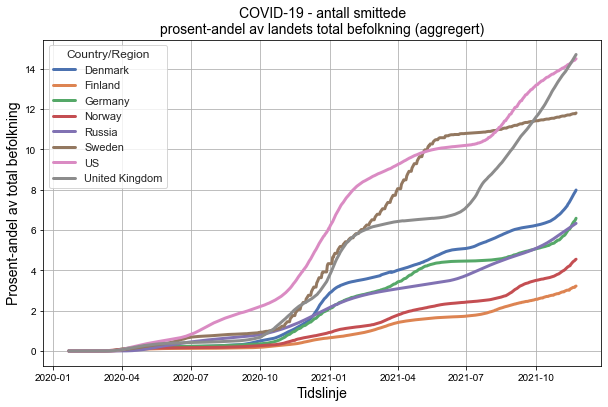

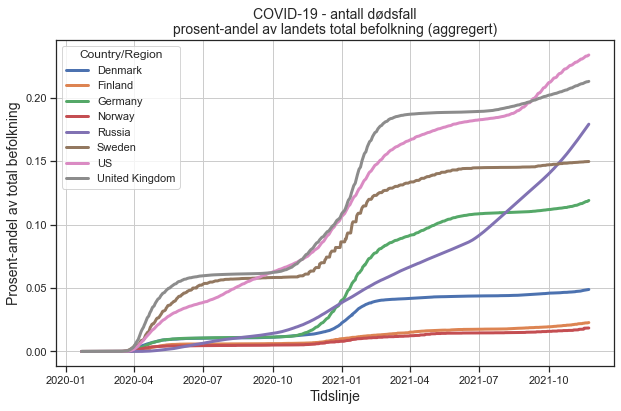

In [52]:
COUNTRY_REGION = 'Country/Region'
CONFIRMED = 'Confirmed'
DEATHS = 'Deaths'
RECOVERED = 'Recovered'

# Create plots for Covid-19 confirmed cases and deaths, fraction of total population
def create_covid_plot2(df, case_type, plot_width=10, plot_height=6):
    case_type_mapping = {'Confirmed': 'smittede', 'Deaths':'dødsfall'}
    df = df.loc[df['Country'].isin(COUNTRIES)] # Select countries we want from total dataframe
    df = df.merge(df_pop_sub, left_on='Country', right_on=COUNTRY_REGION, how='left')
    df['Date'] = df['Date'].map(lambda x: datetime.strptime(x, '%Y-%m-%d'))
    df['cases_by_pop'] = \
        (df[case_type] / df['Current_population'].astype(int)) * 100
    fig, ax = plt.subplots(1,1, figsize=(plot_width, plot_height))
    sns.set(style='ticks', rc={'lines.linewidth': 3})
    sns.lineplot(x='Date', y='cases_by_pop', hue=COUNTRY_REGION, data=df, ax=ax)
    ax.set_xlabel('Tidslinje', size=14)
    ax.set_ylabel('Prosent-andel av total befolkning', size=14)
    # Change some of the plot font size defaults
    ax.set_title(f'COVID-19 - antall {case_type_mapping[case_type]}\nprosent-andel av landets total befolkning (aggregert)',
                 size=14)
    plt.grid()
    plt.show()

create_covid_plot2(df, CONFIRMED)
create_covid_plot2(df, DEATHS)
# create_covid_plot2(df_cases, RECOVERED)

### (TODO, droppe?) Lag verdenskart med 'heatmap' for Covid-19 datasett

In [226]:
# https://ramiro.org/notebook/geopandas-choropleth/
# http://www.naturalearthdata.com/downloads/10m-cultural-vectors/

# Country dimension vals
response = requests.get('https://ghoapi.azureedge.net/api/DIMENSION/COUNTRY/DimensionValues')
json.loads(response.text)

# Get ISO country codes
df_iso_codes = pd.read_csv('https://gist.githubusercontent.com/tadast/8827699/raw/' + 
                           'f5cac3d42d16b78348610fc4ec301e9234f82821/countries_codes_and_coordinates.csv')

# TODO: Get ISO country codes here:
# https://data.norge.no/datasets/21b8e420-542f-4d81-a1f1-abe70aa24679

# Remove superfluous quotes
for col in df_iso_codes.columns:
    df_iso_codes[col] = df_iso_codes[col].map(lambda x: x.replace('"', ''))

# print(df_iso_codes.head())
df_iso_codes['Latitude (average)'] = df_iso_codes['Latitude (average)'].astype(float)
df_iso_codes['Longitude (average)'] = df_iso_codes['Longitude (average)'].astype(float)
df_iso_codes.head()

,Country,Alpha-2 code,Alpha-3 code,Numeric code,Latitude (average),Longitude (average)
0,Afghanistan,AF,AFG,4,33.0000,65.0
1,Albania,AL,ALB,8,41.0000,20.0
2,Algeria,DZ,DZA,12,28.0000,3.0
3,American Samoa,AS,ASM,16,-14.3333,-170.0
4,Andorra,AD,AND,20,42.5000,1.6


### Eksempel 3: Predikere om en film er god eller dårlig (data fra datasjø)
Enkelt maskinlærings-eksempel der vi predikerer om en fin er god eller dårlig. Vi benytter en NLP-teknikk som heter
"tf-idf" (term-frequency - inverse document frequency) og en linær ML-modell basert på Support Vector Machine-algoritmen.

In [116]:
# Movie reviews

# TODO, try others?
# https://github.com/nas5w/imdb-data
# https://github.com/maazh/IMDB-Movie-Dataset-Analysis/blob/master/tmdb-movies.csv

df_movies = dl.get_data('MovieReviews/moviereviews.csv')
print('Størrelse på datasett:', df_movies.shape)
df_movies.head(n=10)

Henter CSV-fil...
Størrelse på datasett: (25000, 2)


,SentimentText,Sentiment
0,"first think another Disney movie, might good, ...",1
1,"Put aside Dr. House repeat missed, Desperate H...",0
2,"big fan Stephen King's work, film made even gr...",1
3,watched horrid thing TV. Needless say one movi...,0
4,truly enjoyed film. acting terrific plot. Jeff...,1
5,"memory ""The Last Hunt"" stuck since saw 1956 13...",1
6,"Shakespeare fan, appreciate Ken Branagh done b...",0
7,privilege watching Scarface big screen beautif...,1
8,real classic. shipload sailors trying get town...,1
9,Serials short subjects originally shown theate...,1


In [66]:
df_movies.Sentiment.value_counts() # Helt balansert target variabel

1    12500
0    12500
Name: Sentiment, dtype: int64

In [125]:
%%time

TEST_SET_SIZE = 0.2
MAX_FEATURES = 200000 # Was: 250000
RANDOM_STATE = 4242
NGRAM_MIN = 1 # Was: 1
NGRAM_MAX = 2 # Was: 3
LABEL = 'Sentiment'
stopwords_to_add = []

train_X, test_X, train_Y, test_Y = train_test_split(df_movies, df_movies[LABEL], stratify=df_movies[LABEL],
                                                    test_size=TEST_SET_SIZE, random_state=RANDOM_STATE)

STOPLIST = stem(set(stopwords.words('english') + list(ENGLISH_STOP_WORDS) + stopwords_to_add))

vectorizer = TfidfVectorizer(sublinear_tf=True, max_df=0.2, stop_words=STOPLIST, analyzer='word',
                             tokenizer=tokenize_and_stem, strip_accents='unicode', norm='l2',
                             lowercase=True,
                             ngram_range=(NGRAM_MIN, NGRAM_MAX), max_features=MAX_FEATURES)

print('Størrelser på trenings- og test-sett:')
print(train_X.shape, test_X.shape)
X_train = vectorizer.fit_transform(train_X['SentimentText'])
X_test = vectorizer.transform(test_X['SentimentText'])
print('tf_idf er klar!')

Størrelser på trenings- og test-sett:
(20000, 2) (5000, 2)


C:\Tools\Utils\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['anywh', 'el', 'elsewh', 'everywh', 'ind', 'otherwi', 'plea', 'somewh'] not in stop_words.
  % sorted(inconsistent)


tf_idf er klar!
Wall time: 2min 6s


In [127]:
model = calibration.CalibratedClassifierCV(multiclass.OneVsRestClassifier(SGDClassifier()))
model.fit(X_train, train_Y)
result = model.score(X_test, test_Y)
print('Riktig predikert: {0:.2f} prosent'.format(result * 100.0))

Riktig predikert: 88.54 prosent


              precision    recall  f1-score   support

 Dårlig film       0.89      0.87      0.88      2500
    God film       0.88      0.90      0.89      2500

    accuracy                           0.89      5000
   macro avg       0.89      0.89      0.89      5000
weighted avg       0.89      0.89      0.89      5000



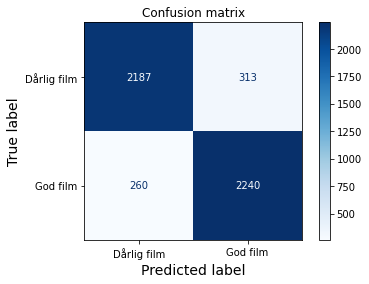

In [128]:
# Predikere på "hold-out" sett
pred = model.predict(X_test)

print(metrics.classification_report(test_Y, pred, target_names=['Dårlig film', 'God film']))

cm = sklearn.metrics.confusion_matrix(test_Y, pred)

fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ConfusionMatrixDisplay.from_estimator(model, X_test, test_Y, ax=ax, 
                                      display_labels=['Dårlig film', 'God film'],
                                      xticks_rotation='horizontal', cmap='Blues')
ax.set_title('Confusion matrix')
plt.show()

### TODO - droppe denne?

In [152]:
# Predikere vin-kvalitet. Datasett fra UCI Machine Learning Repository
df_red = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv', sep=';')
df_white = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv', sep=';')
df_white.head()

df_wine = df_white

3 9 fixed acidity           float64
volatile acidity        float64
citric acid             float64
residual sugar          float64
chlorides               float64
free sulfur dioxide     float64
total sulfur dioxide    float64
density                 float64
pH                      float64
sulphates               float64
alcohol                 float64
quality                   int64
dtype: object fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64
0    3838
1    1060
Name: quality_binned, dtype: int64
0
(3281, 11) (1617, 11)


Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol'],
      dtype='object')

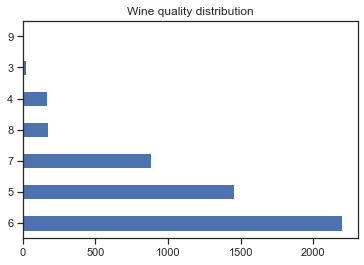

In [153]:
# We have very limited support for some quality categories, try binning to create a binary target
df_wine['quality'].value_counts().plot(kind='barh').set_title('Wine quality distribution')

print(np.min(df_wine['quality']), np.max(df_wine['quality']), df_wine.dtypes, df_wine.isnull().sum())

bins = [np.min(df_wine['quality']) - 1, 6.5, np.max(df_wine['quality'])]
df_wine['quality_binned'] = pd.cut(df_wine['quality'], bins=bins, labels=[0, 1])
print(df_wine['quality_binned'].value_counts())
# print(df_wine.describe())
X = df_wine.drop(['quality', 'quality_binned'], axis=1) # df_red.loc[:, df_red.columns != 'quality']
y = df_wine['quality_binned']
print(y.isnull().sum())
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.33, random_state=1234)
print(X_train.shape, X_test.shape)
X_train.columns

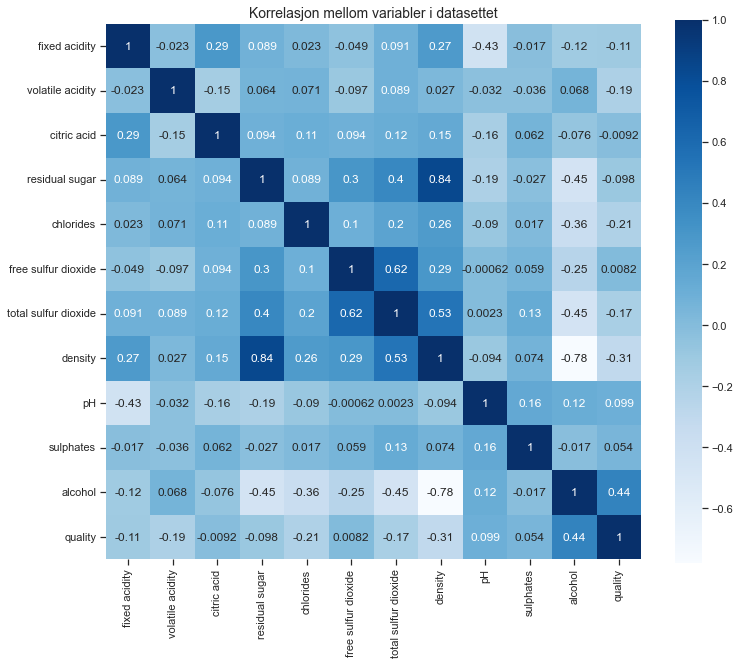

In [155]:
# Show correlation between variables. Are some of the variables better regarding correlation with the target variable?
correlation = df_wine.corr()

fig = plt.subplots(figsize=(12, 10))
sns.heatmap(correlation, vmax=1, square=True, annot=True,
            cmap='Blues').set_title('Korrelasjon mellom variabler i datasettet', size=14)
plt.show()

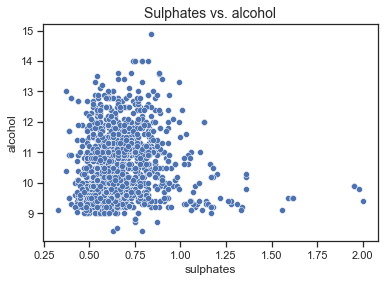

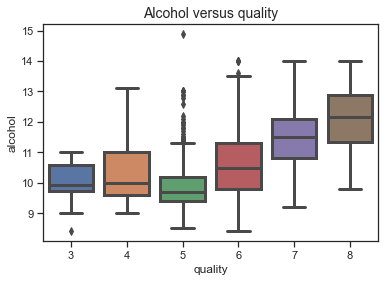

In [162]:
# sns.pairplot(df_red[['alcohol','quality','sulphates','volatile acidity','citric acid']])
sns.scatterplot(x='sulphates', y='alcohol', data=df_red).set_title('Sulphates vs. alcohol', size=14)
plt.show()
sns.boxplot(x='quality', y='alcohol', data=df_red).set_title('Alcohol versus quality', size=14)
plt.show()

In [ ]:
# class sklearn.linear_model.SGDClassifier(loss='hinge', *, penalty='l2', alpha=0.0001, l1_ratio=0.15,
# fit_intercept=True, max_iter=1000, tol=0.001, shuffle=True, verbose=0, epsilon=0.1, n_jobs=None, random_state=None,
# learning_rate='optimal', eta0=0.0, power_t=0.5, early_stopping=False, validation_fraction=0.1, n_iter_no_change=5,
# class_weight=None, warm_start=False, average=False)[source]

In [128]:
clf = make_pipeline(StandardScaler(),
                    SGDClassifier(max_iter=1000, tol=1e-3))

clf.fit(X_train, y_train)
pred = clf.predict(X_test)
print(classification_report(y_test, pred))
confusion_matrix(y_test, pred)

              precision    recall  f1-score   support

           0       0.83      0.93      0.88      1267
           1       0.55      0.30      0.39       350

    accuracy                           0.80      1617
   macro avg       0.69      0.62      0.63      1617
weighted avg       0.77      0.80      0.77      1617



array([[1182,   85],
       [ 244,  106]], dtype=int64)

In [129]:
# Simple grid search to find the best parameters for SVC model
svc = SVC()

param = {
    'C': [0.1, 0.2, 0.5, 0.8, 0.9, 1, 1.1, 1.2, 1.3],
    'kernel':['linear', 'rbf'],
    'gamma' :[0.1, 0.2, 0.3, 0.5, 0.7, 0.8, 0.9, 1., 1.1]
}
#param = {
#    'C': [0.1, 0.2, 0.3],
#    'kernel':['linear', 'rbf'],
#    'gamma' :[0.1, 0.2, 0.3]
#}
grid_svc = GridSearchCV(svc, param_grid=param, scoring='accuracy', cv=2)

grid_svc.fit(X_train, y_train)

GridSearchCV(cv=2, estimator=SVC(),
             param_grid={'C': [0.1, 0.2, 0.5, 0.8, 0.9, 1, 1.1, 1.2, 1.3],
                         'gamma': [0.1, 0.2, 0.3, 0.5, 0.7, 0.8, 0.9, 1.0, 1.1],
                         'kernel': ['linear', 'rbf']},
             scoring='accuracy')

In [117]:
params = grid_svc.best_params_
params

{'C': 1.2, 'gamma': 0.2, 'kernel': 'rbf'}

In [118]:
svc_best = SVC(C=params['C'], gamma=params['gamma'], kernel=params['kernel'])
svc_best.fit(X_train, y_train)
pred_svc_best = svc_best.predict(X_test)
print(classification_report(y_test, pred_svc_best))

              precision    recall  f1-score   support

           0       0.89      0.99      0.94       456
           1       0.76      0.22      0.34        72

    accuracy                           0.88       528
   macro avg       0.83      0.61      0.64       528
weighted avg       0.87      0.88      0.86       528



In [119]:
confusion_matrix(y_test, pred_svc_best)

array([[451,   5],
       [ 56,  16]], dtype=int64)